# **Relax Data Science Challenge**

### *Detecting Encoding*

In [4]:
# Import library for encoding detection
import chardet

# Create list of files to read
files = ['takehome_users.csv', 'takehome_user_engagement.csv']

In [5]:
# Read the first few thousand bytes of the file to detect encoding
encoding = []
for file in files:
    with open(file, "rb") as f:
        result = chardet.detect(f.read(10000))  # Read a sample
        detected_encoding = result["encoding"]
        encoding.append(detected_encoding)

print("Detected Encoding:", encoding)

Detected Encoding: ['ISO-8859-1', 'ascii']


### *Reading in CSV files*

In [7]:
# Import pandas to read csv files
import pandas as pd

users = pd.read_csv('takehome_users.csv', encoding=encoding[0])
engagement = pd.read_csv('takehome_user_engagement.csv', encoding=encoding[1])

# Looking at data types
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:
# Looking at engagement DataFrame
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [9]:
# Parse dates
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


### *Finding Adopted Users*

In [11]:
# Collecting ids of users with at least 3 logins across entire time frame of dataset
counts = engagement.groupby('user_id')['visited'].sum()
ids = counts[counts >= 3].index
len(ids)

2248

In [12]:
# Checking that login counts are for unique dates
for id in ids:
    df = engagement[engagement['user_id'] == id]
    length = []
    for datetime in df['time_stamp']:
        date = datetime.date()
        length.append(date)
        
    counts[id] = len(set(length))

In [13]:
# Verifying count
ids = counts[counts >= 3].index
len(ids)

2248

In [14]:
# Importing datetime to create seven day ranges
from datetime import timedelta

start_date = engagement['time_stamp']
end_date = engagement['time_stamp'] + timedelta(days=7)
engagement['range'] = [*zip(start_date, end_date)]

In [15]:
# Creating counts for logins within seven day range
# Initializing empty list
counts = []

# Iterating over id numbers
for id in ids:

    # Subsetting data by id numbers
    df = engagement[engagement['user_id'] == id]

    # Iterating over ranges in each subset
    for start, end in df['range']:

        # Creating empty list for counts
        to_sum = []

        # Iterating over dates in each subset
        for date in df['time_stamp']:

            # Creating conditional to see if date is in range
            if start <= date <= end:
                count = 1

            else:
                count = 0

            # Appending result to appropriate list
            to_sum.append(count)

        # Appending sum for each range to counts list
        counts.append(sum(to_sum))

In [16]:
# Creating DataFrame with only users of interest
df = engagement[engagement['user_id'].isin(ids)]

# Creating new column with login counts for seven-day period corresponding to range column
df.loc[:, ['daily_logins_within_range']] = counts
df.head()

,time_stamp,user_id,visited,range,daily_logins_within_range
1,2013-11-15 03:45:04,2,1,"(2013-11-15 03:45:04, 2013-11-22 03:45:04)",1
2,2013-11-29 03:45:04,2,1,"(2013-11-29 03:45:04, 2013-12-06 03:45:04)",1
3,2013-12-09 03:45:04,2,1,"(2013-12-09 03:45:04, 2013-12-16 03:45:04)",1
4,2013-12-25 03:45:04,2,1,"(2013-12-25 03:45:04, 2014-01-01 03:45:04)",2
5,2013-12-31 03:45:04,2,1,"(2013-12-31 03:45:04, 2014-01-07 03:45:04)",1


In [17]:
# Grouping by user and finding their max daily logins for a given seven day period
max_logins = df.groupby('user_id')['daily_logins_within_range'].max()

# Collecting user ids for users with at least three daily logins for at least one seven-day period
user_ids = max_logins[max_logins >= 3].index

In [18]:
print(f"There are {len(user_ids)} adopted users in this dataset.")

There are 1656 adopted users in this dataset.


### *Pre-processing*

In [20]:
# Gathering info on users DataFrame
print(users.info())
print("\n")
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None




,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [21]:
# Creating a DataFrame for two purposes:
# Use collected ids for adopted users, changing column name to 'object_id' to match users table for better merging
# Indicate adopted users so information is reflected in users table after the merge
ids = pd.DataFrame({'object_id': user_ids,
                    'adopted_user': 1})

In [22]:
# Left join to keep all data from users table, resulting in null values for non-adopted users
names = users.merge(ids, how='left', on='object_id')

# Filling in missing values
names['adopted_user'].fillna(0, inplace=True)
names.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [23]:
# Setting object_id as index
names.set_index('object_id', inplace=True)

# Parsing dates
names['creation_time'] = pd.to_datetime(names['creation_time'])
names['last_session_creation_time'] = pd.to_datetime(names['last_session_creation_time'], unit='s')

# Dropping columns not useful to model (mostly id variables)
names = names.drop(["name", "email", "org_id", "invited_by_user_id"], axis=1)
names.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1 to 12000
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  8823 non-null   datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   adopted_user                12000 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 656.2+ KB


In [24]:
# Subsetting DataFrame by missing values
missing = names[names['last_session_creation_time'].isna()]

# Filling in missing values with last known creation time (initial creation_time value)
names['last_session_creation_time'].fillna(missing['creation_time'], inplace=True)
names.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1 to 12000
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  12000 non-null  datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   adopted_user                12000 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 656.2+ KB


In [25]:
# Encoding categorical variables in creation_source
names = pd.get_dummies(names, drop_first=True)
names.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,
1,2014-04-22 03:53:30,2014-04-22 03:53:30,1,0,0.0,False,False,False,False
2,2013-11-15 03:45:04,2014-03-31 03:45:04,0,0,1.0,True,False,False,False
3,2013-03-19 23:14:52,2013-03-19 23:14:52,0,0,0.0,True,False,False,False
4,2013-05-21 08:09:28,2013-05-22 08:09:28,0,0,0.0,False,False,False,False
5,2013-01-17 10:14:20,2013-01-22 10:14:20,0,0,0.0,False,False,False,False


### *Model Building*

In [27]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

# init setup on exp
exp.setup(names, target = 'adopted_user', session_id = 123)

,Description,Value
0,Session id,123
1,Target,adopted_user
2,Target type,Binary
3,Original data shape,"(12000, 9)"
4,Transformed data shape,"(12000, 13)"
5,Transformed train set shape,"(8400, 13)"
6,Transformed test set shape,"(3600, 13)"
7,Numeric features,2
8,Date features,2
9,Preprocess,True


In [28]:
# compare baseline models
best = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9706,0.9901,0.8567,0.9246,0.8889,0.8720,0.8731,0.3230
catboost,CatBoost Classifier,0.9696,0.9912,0.8671,0.9091,0.8870,0.8695,0.8702,2.4540
lightgbm,Light Gradient Boosting Machine,0.9690,0.9892,0.8585,0.9122,0.8841,0.8662,0.8671,1.0530
lr,Logistic Regression,0.9677,0.9913,0.7851,0.9765,0.8696,0.8514,0.8585,1.1400
rf,Random Forest Classifier,0.9656,0.9901,0.8257,0.9167,0.8683,0.8486,0.8504,0.3140
et,Extra Trees Classifier,0.9635,0.9880,0.8119,0.9135,0.8593,0.8384,0.8406,0.2950
ada,Ada Boost Classifier,0.9601,0.9617,0.7282,0.9769,0.8333,0.8112,0.8232,0.1570
dt,Decision Tree Classifier,0.9594,0.9107,0.8404,0.8616,0.8504,0.8270,0.8273,0.0390
qda,Quadratic Discriminant Analysis,0.9532,0.9824,0.9336,0.7747,0.8464,0.8191,0.8243,0.0450
knn,K Neighbors Classifier,0.9494,0.9527,0.7704,0.8491,0.8073,0.7783,0.7799,1.7950


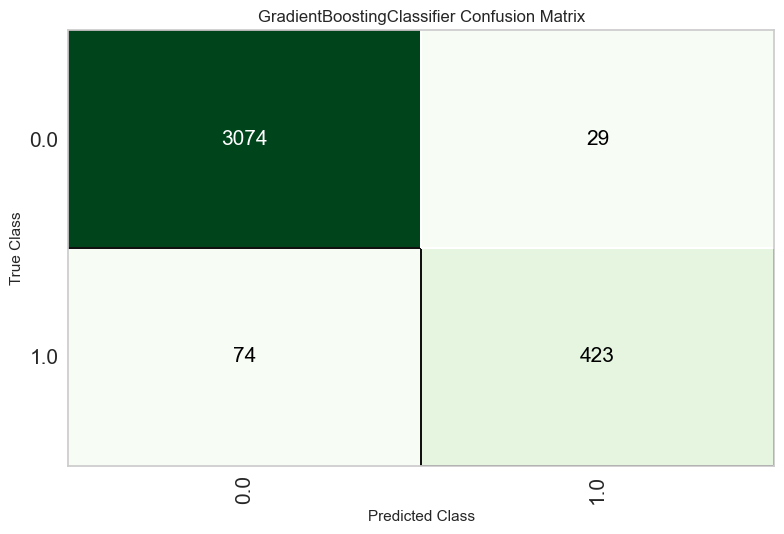

In [29]:
# plotting confusion matrix to confirm results
exp.plot_model(best, plot = 'confusion_matrix')

In [30]:
# saving pipeline for easier implementation
exp.save_model(best, 'Relax_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None,
                                     include=['creation_time',
                                              'last_session_creation_time'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['opted_in_to_mailing_list',
                                              'enabled_for_marketing_drip'],
                                     tr...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='log_loss',
 

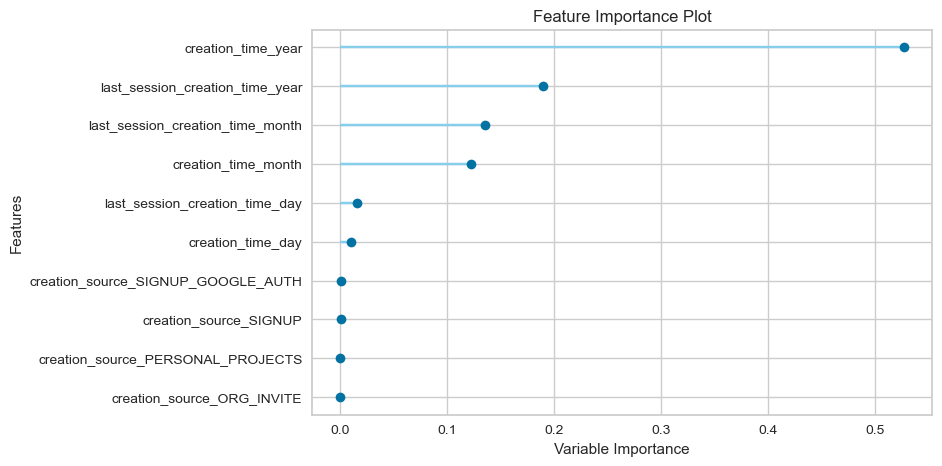

In [31]:
# extracting important features
exp.plot_model(best, plot = 'feature')

It seems that creation time variables are the most important in determining user adoption. There may be some collinearity exaggerating the effects of these features since all missing last_session_creation_time variables were imputed with their corresponding creation_time variable, but given the definition of an adopted user, the presence of these features makes intuitive sense. In order to create this variable, logins from the engagement table were used and these logins are partially reflected in the users table. In other words, more activity results in a greater chance of user adoption.